In [16]:
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Modeling Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Optimization & Validation
import optuna
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Mute warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("whitegrid")

# Define Paths
TRAIN_PATH = os.path.join('..', 'data', 'processed', 'train_features.parquet')
TEST_PATH = os.path.join('..', 'data', 'processed', 'test_features.parquet')

In [17]:
print("Loading data...")
train = pd.read_parquet(TRAIN_PATH)
test = pd.read_parquet(TEST_PATH)

# 1. Define Redundant Features to Drop
features_to_drop = ['Time_relative_max_y', 'Flux_corrected_std_g', 'SNR_obs_max_i', 'SNR_obs_max_r', 'Time_relative_max_i', 'luminosity_max_i', 'Time_relative_max_r', 'flux_blue_sum', 'amplitude_u', 'amplitude_r', 'Time_relative_count_y', 'Time_relative_count_i', 'SNR_obs_max_u', 'Flux_corrected_std_z', 'Time_relative_count_u', 'z_distance_proxy', 'Flux_corrected_std_u', 'Time_relative_max_u', 'Flux_corrected_mean_r', 'Flux_err_corrected_mean_u', 'Time_relative_max_z', 'amplitude_g', 'Time_relative_count_z', 'flux_red_sum', 'SNR_obs_max_z', 'Time_relative_count_r', 'Flux_corrected_mean_z', 'SNR_obs_max_y']

# List of substrings to search for in column names
err_list = [
    'Flux_err_corrected',  # The main one you wanted to drop
    'Flux_corrected_err',  # Just in case of typos
    'Z_err',
    '_y',
    '_z',
]

# Dynamically find columns that contain ANY string from err_list
error_features = [c for c in train.columns if any(e in c for e in err_list)]

print(f"Dropping {len(error_features)} error-related features: {error_features}")

# Combine lists (using set to avoid duplicates)
final_drop_list = list(set(features_to_drop + error_features))

# 3. Prepare X and y
# Drop IDs, Targets, and the combined list of features
X = train.drop(columns=['object_id', 'target', 'Z_err'] + final_drop_list, errors='ignore')
y = train['target']
object_ids_test = test['object_id']

# 4. Prepare Test Set (Align columns)
X_test = test.drop(columns=['object_id', 'Z_err'] + final_drop_list, errors='ignore')
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# 5. Clean Column Names for LightGBM
def clean_cols(df):
    return [re.sub(r'[^A-Za-z0-9_]+', '_', str(c)) for c in df.columns]

X.columns = clean_cols(X)
X_test.columns = clean_cols(X_test)

print(f"Data Loaded. Train Shape: {X.shape}")
print(f"Class Imbalance: {y.value_counts().to_dict()}")

Loading data...
Dropping 35 error-related features: ['Flux_corrected_mean_y', 'Flux_corrected_mean_z', 'Flux_corrected_max_y', 'Flux_corrected_max_z', 'Flux_corrected_min_y', 'Flux_corrected_min_z', 'Flux_corrected_std_y', 'Flux_corrected_std_z', 'Flux_corrected_skew_y', 'Flux_corrected_skew_z', 'Flux_change_rate_mean_y', 'Flux_change_rate_mean_z', 'Flux_change_rate_max_y', 'Flux_change_rate_max_z', 'Flux_change_rate_std_y', 'Flux_change_rate_std_z', 'Time_relative_max_y', 'Time_relative_max_z', 'Time_relative_count_y', 'Time_relative_count_z', 'Flux_err_corrected_mean_g', 'Flux_err_corrected_mean_i', 'Flux_err_corrected_mean_r', 'Flux_err_corrected_mean_u', 'Flux_err_corrected_mean_y', 'Flux_err_corrected_mean_z', 'SNR_obs_max_y', 'SNR_obs_max_z', 'Delta_flux_sq_mean_y', 'Delta_flux_sq_mean_z', 'Time_of_max_flux_y', 'Time_of_max_flux_z', 'Time_of_min_flux_y', 'Time_of_min_flux_z', 'Z_err']
Data Loaded. Train Shape: (3043, 57)
Class Imbalance: {0: 2895, 1: 148}


In [18]:
def objective_xgb(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 40),
        'early_stopping_rounds': 50,
        'n_jobs': -1,
        'random_state': 42
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        clf = xgb.XGBClassifier(**param)
        clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = clf.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, preds)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        f1_scores.append(np.max(f1))
        
    return np.mean(f1_scores)

def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'average_precision',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 40),
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        clf = lgb.LGBMClassifier(**param)
        callbacks = [lgb.early_stopping(50, verbose=False)]
        clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='average_precision', callbacks=callbacks)
        
        preds = clf.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, preds)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        f1_scores.append(np.max(f1))
        
    return np.mean(f1_scores)

def objective_cat(trial):
    param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 40),
        'eval_metric': 'PRAUC',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'allow_writing_files': False,
        'random_seed': 42
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        
        clf = CatBoostClassifier(**param)
        clf.fit(X_tr, y_tr, eval_set=(X_val, y_val))
        
        preds = clf.predict_proba(X_val)[:, 1]
        prec, rec, _ = precision_recall_curve(y_val, preds)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        f1_scores.append(np.max(f1))
        
    return np.mean(f1_scores)

In [19]:
print("--- Optimizing XGBoost ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
print(f"Best XGB F1: {study_xgb.best_value:.4f}")

print("\n--- Optimizing LightGBM ---")
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)
print(f"Best LGB F1: {study_lgb.best_value:.4f}")

print("\n--- Optimizing CatBoost ---")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=20) # CatBoost is slower, fewer trials
print(f"Best Cat F1: {study_cat.best_value:.4f}")

--- Optimizing XGBoost ---


Best XGB F1: 0.4328

--- Optimizing LightGBM ---
Best LGB F1: 0.4454

--- Optimizing CatBoost ---
Best Cat F1: 0.4369


In [20]:
# Function to get robust OOF and Test predictions
def train_robust_model(model_type, best_params, X, y, X_test):
    n_splits = 5
    n_repeats = 5
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    oof_probs = np.zeros(len(y))
    test_probs = np.zeros(len(X_test))
    
    print(f"Training Robust {model_type}...")
    
    for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if model_type == 'XGB':
            params = best_params.copy()
            params.update({'n_estimators': 3000, 'n_jobs': -1, 'random_state': 42, 'early_stopping_rounds': 150, 'objective': 'binary:logistic', 'eval_metric': 'aucpr'})
            clf = xgb.XGBClassifier(**params)
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            
        elif model_type == 'LGB':
            params = best_params.copy()
            params.update({'n_estimators': 3000, 'n_jobs': -1, 'random_state': 42, 'objective': 'binary', 'metric': 'average_precision', 'verbosity': -1})
            clf = lgb.LGBMClassifier(**params)
            callbacks = [lgb.early_stopping(150, verbose=False)]
            clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='average_precision', callbacks=callbacks)
            
        elif model_type == 'CAT':
            params = best_params.copy()
            params.update({'iterations': 3000, 'eval_metric': 'PRAUC', 'early_stopping_rounds': 150, 'verbose': 0, 'allow_writing_files': False, 'random_seed': 42})
            clf = CatBoostClassifier(**params)
            clf.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            
        # Accumulate predictions
        oof_probs[val_idx] += clf.predict_proba(X_val)[:, 1]
        test_probs += clf.predict_proba(X_test)[:, 1]
        
        if (fold+1) % 5 == 0:
            print(f"Fold {fold+1}/{n_splits*n_repeats} complete.")
            
    # Average results
    oof_probs /= n_repeats
    test_probs /= (n_splits * n_repeats)
    
    return oof_probs, test_probs

# --- EXECUTE FINAL TRAINING ---
oof_xgb, test_xgb = train_robust_model('XGB', study_xgb.best_params, X, y, X_test)
oof_lgb, test_lgb = train_robust_model('LGB', study_lgb.best_params, X, y, X_test)
oof_cat, test_cat = train_robust_model('CAT', study_cat.best_params, X, y, X_test)

Training Robust XGB...
Fold 5/25 complete.
Fold 10/25 complete.
Fold 15/25 complete.
Fold 20/25 complete.
Fold 25/25 complete.
Training Robust LGB...
Fold 5/25 complete.
Fold 10/25 complete.
Fold 15/25 complete.
Fold 20/25 complete.
Fold 25/25 complete.
Training Robust CAT...
Fold 5/25 complete.
Fold 10/25 complete.
Fold 15/25 complete.
Fold 20/25 complete.
Fold 25/25 complete.


Creating Ensemble...

Optimal Ensemble Threshold: 0.3456
Best Ensemble F1 Score: 0.4591

--- Final Ensemble Report ---
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2895
           1       0.38      0.59      0.46       148

    accuracy                           0.93      3043
   macro avg       0.68      0.77      0.71      3043
weighted avg       0.95      0.93      0.94      3043



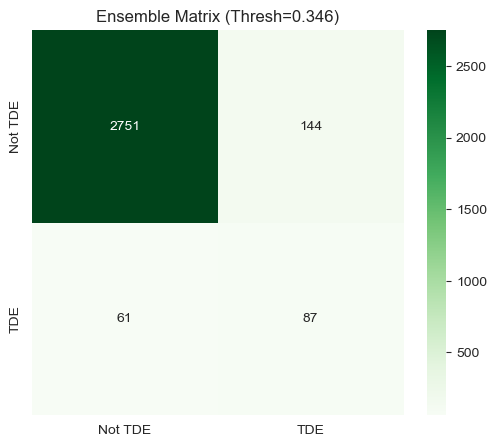

In [21]:
# 1. Average OOF Predictions (Ensemble)
print("Creating Ensemble...")
oof_ensemble = (oof_xgb + oof_lgb + oof_cat) / 3

# 2. Find Optimal Threshold on Ensemble
precisions, recalls, thresholds = precision_recall_curve(y, oof_ensemble)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"\nOptimal Ensemble Threshold: {best_thresh:.4f}")
print(f"Best Ensemble F1 Score: {f1_scores[best_idx]:.4f}")

# 3. Validation Report
y_pred_ensemble = (oof_ensemble >= best_thresh).astype(int)
print("\n--- Final Ensemble Report ---")
print(classification_report(y, y_pred_ensemble))

# 4. Confusion Matrix
cm = confusion_matrix(y, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Not TDE', 'TDE'], yticklabels=['Not TDE', 'TDE'])
plt.title(f'Ensemble Matrix (Thresh={best_thresh:.3f})')
plt.show()

In [22]:
# 1. Average Test Predictions
test_probs_ensemble = (test_xgb + test_lgb + test_cat) / 3

# 2. Apply Threshold
print(f"Applying threshold: {best_thresh:.4f}")
test_preds_binary = (test_probs_ensemble >= best_thresh).astype(int)

# 3. Create Submission File
submission = pd.DataFrame({
    'object_id': object_ids_test,
    'prediction': test_preds_binary
})

# 4. Save
submission.to_csv('submission.csv', index=False)
print("Saved 'submission.csv' successfully.")
print(submission.head())

Applying threshold: 0.3456
Saved 'submission.csv' successfully.
                   object_id  prediction
0            Elrim_sador_hun           0
1   Eluwaith_Mithrim_nothrim           0
2         Eru_heledir_archam           0
3          Gonhir_anann_fuin           0
4  Gwathuirim_eilian_fervain           0
